In [1]:
import sys
sys.path.append("../../")

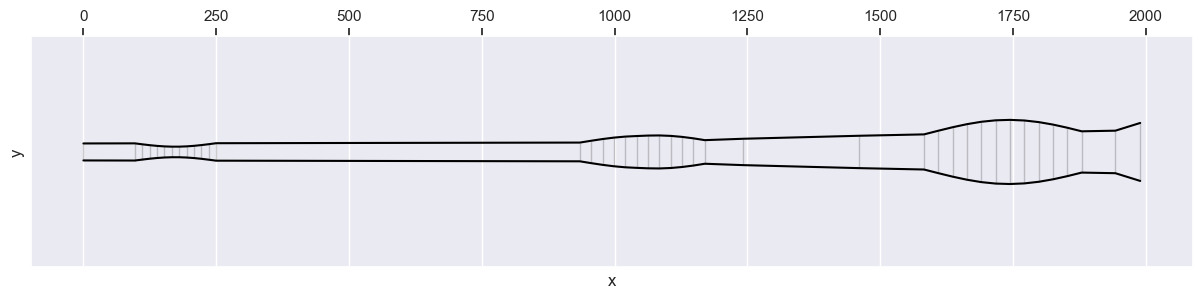

In [12]:
from didgelab.evo.nuevolution import GeoGenome
from didgelab.calc.geo import Geo, geotools
from didgelab.util.didge_visualizer import vis_didge
import math
import numpy as np
from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies

class MbeyaGemome(GeoGenome):

    def add_param(self, name, minval, maxval):
        self.named_params[name] = {
            "index": len(self.named_params),
            "min": minval,
            "max": maxval
        }

    def get_value(self, name):
        p = self.named_params[name]
        v = self.genome[p["index"]]
        v = v*(p["max"]-p["min"]) + p["min"]
        return v


    def __init__(self, n_bubbles=3, add_bubble_prob=0.7):

        self.named_params = {}

        self.d1=32
        self.add_bubble_prob=add_bubble_prob
        self.n_bubbles=n_bubbles

        # straight part
        self.add_param("l_gerade", 500, 1500)
        self.add_param("d_gerade", 0.9, 1.2)

        # opening part
        self.add_param("n_opening_segments", 0, 8)
        self.add_param("opening_factor_x", -2, 2)
        self.add_param("opening_factor_y", -2, 2)
        self.add_param("opening_length", 700, 1000)

        # bell
        self.add_param("d_pre_bell", 40, 50)
        self.add_param("l_bell", 20, 50)
        self.add_param("bellsize", 5, 30)

        # bubble
        for i in range(self.n_bubbles):
            self.add_param(f"add_bubble_{i}", 0, 1)
            self.add_param(f"bubble_height_{i}", -0.5, 1)
            self.add_param(f"bubble_pos_{i}", 0, 1)
            self.add_param(f"bubble_width_{i}", 150, 300)

        self.n_segments = 11

        GeoGenome.__init__(self, n_genes = len(self.named_params))

    def make_bubble(self, shape, pos, width, height):

        i=self.get_index(shape, pos-0.5*width)

        bubbleshape=shape[0:i]

        x=pos-0.5*width
        y=Geo(geo=shape).diameter_at_x(x)

        if shape[i-1][0]<x:
            bubbleshape.append([x,y])

        for j in range(1,self.n_segments):
            x=pos-0.5*width + j*width/self.n_segments

            # get diameter at x
            y=Geo(geo=shape).diameter_at_x(x)
            factor=1+math.sin(j*math.pi/(self.n_segments))*height
            y*=factor

            bubbleshape.append([x,y])

        x=pos+0.5*width
        y=Geo(geo=shape).diameter_at_x(x)
        bubbleshape.append([x,y])

        while shape[i][0]<=bubbleshape[-1][0]+1:
            i+=1
        
        bubbleshape.extend(shape[i:])

        return bubbleshape

    # return last index that is smaller than x
    def get_index(self, shape, x):
        for i in range(len(shape)):
            if shape[i][0]>x:
                return i
        return len(shape)-1

    def genome2geo(self):
        shape=[[0, self.d1]]

        # straight part
        p=[self.get_value("l_gerade"), shape[-1][1]*self.get_value("d_gerade")]
        shape.append(p)

        # opening part
        n_seg=self.get_value("n_opening_segments")
        seg_x=[]
        seg_y=[]
        for i in range(int(n_seg)):
            x=pow(i+1, self.get_value("opening_factor_x"))
            y=pow(i+1, self.get_value("opening_factor_y"))
            seg_x.append(x)
            seg_y.append(y)

        def normalize(arr):
            m=sum(arr)
            return [x/m for x in arr]

        seg_x=normalize(seg_x)
        seg_y=normalize(seg_y)
        seg_x=[x*self.get_value("opening_length") for x in seg_x]
        seg_y=[y*self.get_value("d_pre_bell") for y in seg_y]

        start_x=shape[-1][0]
        start_y=shape[-1][1]
        for i in range(int(n_seg)):
            x=sum(seg_x[0:i+1]) + start_x
            y=sum(seg_y[0:i+1]) + start_y
            shape.append([x,y])

        p=[shape[-1][0] + self.get_value("l_bell"), shape[-1][1]+self.get_value("bellsize")]
        shape.append(p)

        # add bubble
        for i in range(self.n_bubbles):
            pos=shape[-1][0]*self.get_value(f"bubble_pos_{i}")
            width=self.get_value(f"bubble_width_{i}")
            height=self.get_value(f"bubble_height_{i}")
            if pos-width/2<-10:
                pos=width/2 + 10
            if pos+width/2+10>shape[-1][0]:
                pos=shape[-1][0]-width/2 - 10
            shape=self.make_bubble(shape, pos, width, height)

        geo=Geo(shape)
        geo=geotools.fix_zero_length_segments(geo)
        return geo

np.random.seed(0)
didge = MbeyaGemome()
didge.n_segments = 11
vis_didge(didge.genome2geo())


In [14]:
didge.n_segments = 11
freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(didge.genome2geo())
impedances = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedances)
notes


,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,C1,47.368344,-33,67.220685,24.817559,1.000000
1,C2,27.368344,-21,132.897179,6.758531,0.272329
2,G2,32.368344,-14,199.696698,2.091060,0.084257
3,C3,27.368344,-9,265.794357,14.917812,0.601099
4,F#3,-2.631656,-3,369.432420,2.842351,0.114530
5,A4,-42.631656,0,429.297313,3.387324,0.136489
6,D4,-17.631656,5,581.378268,1.412268,0.056906
7,E4,2.368344,7,660.157598,0.220206,0.008873
8,G4,-7.631656,10,780.542476,0.570269,0.022978
9,A5,-42.631656,12,858.594626,0.205565,0.008283


In [15]:
didge.n_segments = 3
freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(didge.genome2geo())
impedances = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedances)
notes


,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,C1,37.368344,-33,66.833522,25.200317,1.000000
1,C2,37.368344,-21,133.667044,6.535101,0.259326
2,G#2,-47.631656,-13,202.017062,2.127843,0.084437
3,C3,47.368344,-9,268.882739,13.135535,0.521245
4,F#3,2.368344,-3,370.500925,2.733123,0.108456
5,A4,-32.631656,0,431.784207,3.660260,0.145247
6,D4,-17.631656,5,581.378268,1.480799,0.058761
7,E4,-2.631656,7,658.253739,0.247137,0.009807
8,G4,-7.631656,10,780.542476,0.683404,0.027119
9,A5,-47.631656,12,856.118485,0.205232,0.008144
